In [116]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Используем один из "игрушечных" датасетов из той же библиотеки.

In [117]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [118]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [119]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta

#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction

# ИЗМЕНЕНИЕ
    predictions = np.array(
        sum([eta * alg.predict(X) for alg in trees_list])
    )
# ИЗМЕНЕНИЕ

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [120]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [121]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [122]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):

    # Деревья будем записывать в список
    trees = []

    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [123]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Для начала определим границы в которых имеет смысл строить графики

In [124]:
# Число деревьев в ансамбле
# n_trees = 50
n_trees = 10

# Максимальная глубина деревьев
# max_depth = 3
max_depth = 5

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [125]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4701.050633520367
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 7624.156384126414


In [126]:
def get_error_plot(n_trees,train_err, test_err):

    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

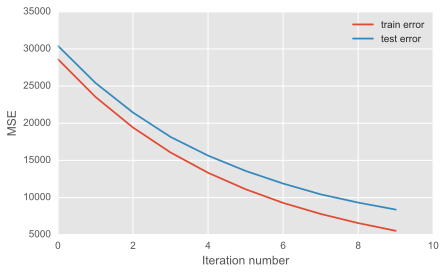

In [127]:
get_error_plot(n_trees, train_errors, test_errors)

Имеет смысл использовать максимальное количество деревьев не больше 12. Возьмем это же значение для максимальной глубины дерева.

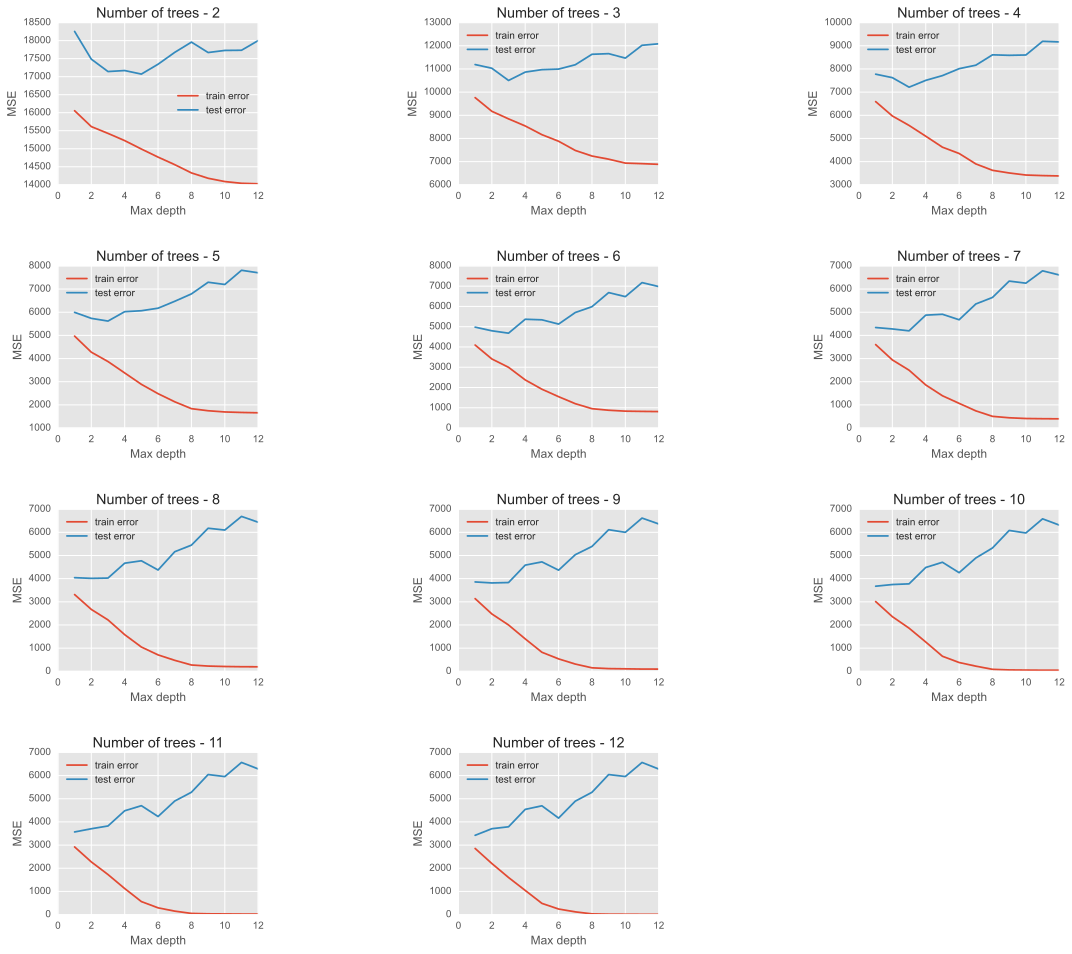

In [131]:
eta = 0.3

n_trees = np.arange(1, 13, 1)
max_depth =  np.arange(1, 13, 1)


fig, axs = plt.subplots(4,3, figsize=(16,16))

fig.subplots_adjust(hspace = 0.5, wspace= 1)
axs = axs.ravel()

mse_train_max_depth = []
mse_test_max_depth = []

for i in n_trees[1:]: # Одно дерево не имеет смысла брать =)

    mse_train_max_depth = []
    mse_test_max_depth = []
    for k in max_depth:
        trees, train_errors, test_errors = gb_fit(i, k, X_train, X_test, y_train, y_test, eta)
        mse_train_max_depth.append(train_errors[-1])
        mse_test_max_depth.append(test_errors[-1])


    axs[i-2].plot(max_depth, mse_train_max_depth, label='train error')
    axs[i-2].plot(max_depth, mse_test_max_depth, label='test error')
    axs[i-2].set_title('Number of trees - %i' % i)
    axs[i-2].set_xlim(0, max_depth[-1])
    axs[i-2].set_xlabel('Max depth')
    axs[i-2].set_ylabel('MSE')
    axs[i-2].legend(loc='best')
axs[len(n_trees[1:])].remove()  # уберем пустой график

Видно, что не смотря на то, что на тренировочных данных ошибка снижается и приближается к 0, на тестовых данных все обстоит не так уж и хорошо. С увеличением глубины дерева и для количества деревьев от 2 до 7 ошибка вначале снижается, а потом возрастает. Для большего количества деревьев ошибка только возрастает, что свидетельствует о переобучении модели.